### Run, train and validate models

Pre-process the data, train and validate models using AUC as the performance metric

In [1]:
import pandas as pd
import numpy as np
import argparse
import os
import sys
import json
import tarfile
import s3fs
import pickle

!pip install xgboost
import xgboost

from sklearn.model_selection import train_test_split

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.s3 import S3Downloader
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    CategoricalParameter,
    HyperparameterTuner,
)
from sagemaker.amazon.amazon_estimator import get_image_uri
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Grocery_Recommender.Model_Build import XGBoost_eval, SKLearn_input_prep
from Grocery_Recommender.Model_Build import plot_hyperparameter_tuning as plt_hyper

sklearn_v = "0.20.0"
role = get_execution_role()
session = sagemaker.Session()

     |████████████████████████████████| 109.8MB 82kB/s s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# create a list of the features to use for modeling

feat_list = [
    "CUST_PRICE_SENSITIVITY",
    "CUST_LIFESTAGE",
    "BASKET_SIZE_PROP_SPEND_PROD_CODE_M",
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_LA",
    "DAY_PART_PROP_SPEND_CUST_CODE_AFTERNOON",
    "BASKET_SIZE_PROP_VISITS_CUST_CODE_L",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Fresh",
    "BASKET_TYPE_PROP_VISITS_CUST_CODE_Small Shop",
    "BASKET_SIZE_PROP_QUANTITY_PROD_CODE_L",
    "STORE_FORMAT_PROP_VISITS_CUST_CODE_MS",
    "CHNG_VISITS_PROD_CODE_30_1_52",
    "STORE_FORMAT_PROP_SPEND_PROD_CODE_LS",
    "STORE_FORMAT_PROP_QUANTITY_CUST_CODE_SS",
    "BASKET_SIZE_QUANTITY_CUST_CODE_S",
    "BASKET_DOMINANT_MISSION_PROP_QUANTITY_PROD_CODE_Nonfood",
    "CHNG_SPEND_PROD_CODE_40_8_52",
    "BASKET_DOMINANT_MISSION_PROP_VISITS_CUST_CODE_XX",
    "BASKET_TYPE_VISITS_CUST_CODE_XX",
    "WKDAY_WKEND_PROP_QUANTITY_CUST_CODE_WEEKEND",
    "BASKET_TYPE_QUANTITY_CUST_CODE_Small Shop",
    "SPEND_PROD_CODE_30_52",
    "BASKET_TYPE_SPEND_CUST_CODE_Top Up",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_CUST_CODE_Grocery",
    "CHNG_QUANTITY_PROD_CODE_40_26_52",
    "SPEND_PROD_CODE_20_52",
    "BASKET_TYPE_PROP_QUANTITY_CUST_CODE_Top Up",
    "VISITS_PROD_CODE_20_52",
    "WKDAY_WKEND_PROP_VISITS_PROD_CODE_WEEKEND",
    "VISITS_PROD_CODE_40_1",
    "CHNG_VISITS_PROD_CODE_40_1_26",
    "BASKET_TYPE_PROP_SPEND_PROD_CODE_XX",
    "STORE_FORMAT_PROP_VISITS_CUST_CODE_XLS",
    "DAY_PART_PROP_VISITS_CUST_CODE_EVENING",
    "TIME_BTWN_MEDIAN_OVERALL_PROD_CODE_40",
    "STORE_FORMAT_PROP_VISITS_PROD_CODE_XLS",
    "DAY_PART_PROP_SPEND_PROD_CODE_MORNING",
    "STORE_FORMAT_PROP_SPEND_PROD_CODE_SS",
    "STORE_FORMAT_PROP_VISITS_PROD_CODE_MS",
    "DAY_PART_PROP_SPEND_CUST_CODE_MORNING",
    "BASKET_PRICE_SENSITIVITY_PROP_SPEND_PROD_CODE_LA",
    "DAY_PART_PROP_QUANTITY_PROD_CODE_EVENING",
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_UM",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Grocery",
    "BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_PROD_CODE_MM",
    "STORE_FORMAT_PROP_SPEND_CUST_CODE_LS",
    "QUANTITY_PROD_CODE_52",
    "BASKET_TYPE_PROP_VISITS_PROD_CODE_Top Up",
    "DAY_PART_PROP_SPEND_PROD_CODE_AFTERNOON",
    "CHNG_VISITS_PROD_CODE_20_1_8",
    "BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_CUST_CODE_MM",
    "BASKET_DOMINANT_MISSION_SPEND_CUST_CODE_XX",
    "USER_factor_0",
    "USER_factor_1",
    "USER_factor_2",
    "USER_factor_3",
    "USER_factor_4",
    "ITEM_factor_0",
    "ITEM_factor_1",
    "ITEM_factor_2",
    "ITEM_factor_3",
    "ITEM_factor_4",
]

In [3]:
sklearn_processor = SKLearnProcessor(
    framework_version=sklearn_v,
    role=role,
    instance_type="ml.m5.xlarge",
    instance_count=1,
)

### Pre-process the data

In [4]:
# Keep only the specified features from the training and test sets that will be used for model developement
input_data_train, input_data_test = SKLearn_input_prep.create_model_input(
    bucket="udacity-machine-learning-capstone-data",
    train_key="train_df_features.csv",
    test_key="test_df_features.csv",
    out_file_train="train_df_final_features.csv",
    out_file_test="test_df_final_features.csv",
    feat_list=feat_list,
)

# Run the pre-processing steps by calling preprocessing.py
sklearn_processor.run(
    code="../Grocery_Recommender/Model_Build/preprocessing.py",
    inputs=[
        ProcessingInput(
            source=input_data_train, destination="/opt/ml/processing/input_data_train"
        ),
        ProcessingInput(
            source=input_data_test, destination="/opt/ml/processing/input_data_test"
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="train_data", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/test"),
        ProcessingOutput(output_name="valid_data", source="/opt/ml/processing/valid"),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "valid_data":
        preprocessed_valid_data = output["S3Output"]["S3Uri"]


Job Name:  sagemaker-scikit-learn-2020-04-04-22-00-51-021
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://udacity-machine-learning-capstone-data/train_df_final_features.csv', 'LocalPath': '/opt/ml/processing/input_data_train', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'S3Input': {'S3Uri': 's3://udacity-machine-learning-capstone-data/test_df_final_features.csv', 'LocalPath': '/opt/ml/processing/input_data_test', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-800613416076/sagemaker-scikit-learn-2020-04-04-22-00-51-021/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs

### Train, tune and evaluate Logistic Regression model

#### Tune the hyperparameters

In [5]:
# Set up the logistic model
logistic_model = SKLearn(
    entry_point="../Grocery_Recommender/Model_Build/train_logistic.py",
    train_instance_type="ml.m5.xlarge",
    hyperparameters={"reg_param": 0.01, "tune": 1},
    role=role,
)

# Set up the hyperparameter tuning job
logistic_hyperparameter_tuner = HyperparameterTuner(
    estimator=logistic_model,
    objective_metric_name="AUC",
    objective_type="Maximize",
    metric_definitions=[{"Name": "AUC", "Regex": "ROC AUC: ([0-9\\.]+)"}],
    max_jobs=20,
    max_parallel_jobs=3,
    hyperparameter_ranges={"reg_param": ContinuousParameter(0, 10)},
)

# Run the hyperparameter tuning job
logistic_hyperparameter_tuner.fit(
    {"train": preprocessed_training_data, "test": preprocessed_test_data}
)
logistic_hyperparameter_tuner.wait()
logistic_hyperparameter_tuner.best_training_job()

# Get analysis on the tuning job including best hyperparameters
tuning_analysis = (
    logistic_hyperparameter_tuner.analytics()
    .dataframe()
    .sort_values(by=["TrainingStartTime"], ascending=False, axis=0)
)
tuning_analysis['iteration'] = tuning_analysis.index
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)

.............................................................................................................................................................................................................................................................!


In [6]:
tuning_analysis

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,reg_param,iteration
0,0.88799,47.0,2020-04-04 22:25:18+00:00,sagemaker-scikit-lea-200404-2204-020-2c192832,Completed,2020-04-04 22:24:31+00:00,8.237190,0
1,0.88799,45.0,2020-04-04 22:25:03+00:00,sagemaker-scikit-lea-200404-2204-019-666592f5,Completed,2020-04-04 22:24:18+00:00,8.147468,1
4,0.88799,41.0,2020-04-04 22:22:13+00:00,sagemaker-scikit-lea-200404-2204-016-2d94a6de,Completed,2020-04-04 22:21:32+00:00,8.420296,4
3,0.88799,47.0,2020-04-04 22:22:07+00:00,sagemaker-scikit-lea-200404-2204-017-f4303db9,Completed,2020-04-04 22:21:20+00:00,7.747688,3
12,0.88799,49.0,2020-04-04 22:13:14+00:00,sagemaker-scikit-lea-200404-2204-008-79a5de52,Completed,2020-04-04 22:12:25+00:00,7.951240,12
13,0.88799,56.0,2020-04-04 22:13:22+00:00,sagemaker-scikit-lea-200404-2204-007-d8784914,Completed,2020-04-04 22:12:26+00:00,8.241463,13
11,0.88799,47.0,2020-04-04 22:13:35+00:00,sagemaker-scikit-lea-200404-2204-009-580964b8,Completed,2020-04-04 22:12:48+00:00,8.787727,11
19,0.88798,77.0,2020-04-04 22:07:38+00:00,sagemaker-scikit-lea-200404-2204-001-3780174d,Completed,2020-04-04 22:06:21+00:00,9.338264,19
17,0.88798,71.0,2020-04-04 22:07:50+00:00,sagemaker-scikit-lea-200404-2204-003-07cea876,Completed,2020-04-04 22:06:39+00:00,6.937774,17
9,0.88798,46.0,2020-04-04 22:16:05+00:00,sagemaker-scikit-lea-200404-2204-011-b1712c9b,Completed,2020-04-04 22:15:19+00:00,3.284187,9


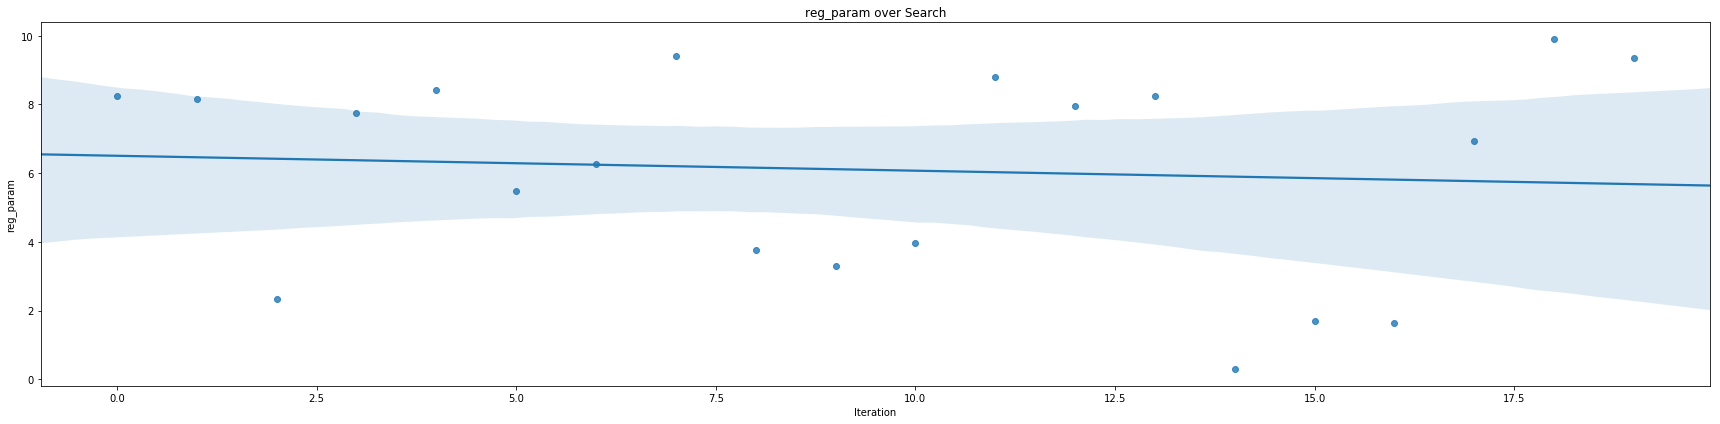

In [7]:
# Plot the value of hyperparameters over the tuning window
plt_hyper.plot_hyperparams_over_search(df=tuning_analysis, hyperparams=["reg_param"])

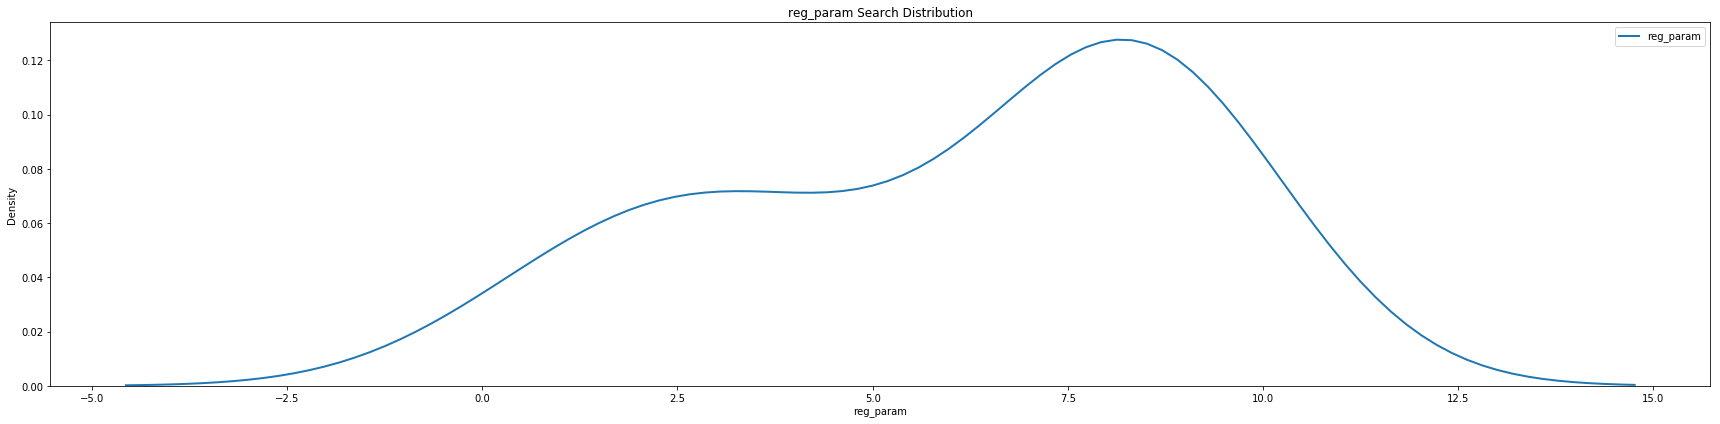

In [8]:
# Create a kde plot of hyperparameters used over the tuning window
plt_hyper.plot_search_dist(df=tuning_analysis, hyperparams=["reg_param"])

In [10]:
# Get the best hyperparameters and refit the model over the training data with the best params
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)
reg_param = tuning_analysis["reg_param"].reset_index(drop=True)[0]

logistic_model = SKLearn(
    entry_point="../Grocery_Recommender/Model_Build/train_logistic.py",
    train_instance_type="ml.m5.xlarge",
    hyperparameters={"reg_param": reg_param, "tune": 0},
    role=role,
)

logistic_model.fit({"train": preprocessed_training_data})
training_job_description = logistic_model.jobs[-1].describe()
model_data_s3_uri = "{}{}/{}".format(
    training_job_description["OutputDataConfig"]["S3OutputPath"],
    training_job_description["TrainingJobName"],
    "output/model.tar.gz",
)

# Run the evaluation on the validation set
sklearn_processor.run(
    code="../Grocery_Recommender/Model_Build/evaluation_sklearn.py",
    inputs=[
        ProcessingInput(
            source=model_data_s3_uri, destination="/opt/ml/processing/model"
        ),
        ProcessingInput(
            source=preprocessed_valid_data, destination="/opt/ml/processing/valid"
        ),
    ],
    outputs=[
        ProcessingOutput(
            output_name="evaluation", source="/opt/ml/processing/evaluation"
        )
    ],
)
evaluation_job_description = sklearn_processor.jobs[-1].describe()

evaluation_output_config = evaluation_job_description["ProcessingOutputConfig"]
for output in evaluation_output_config["Outputs"]:
    if output["OutputName"] == "evaluation":
        evaluation_s3_uri = output["S3Output"]["S3Uri"] + "/evaluation.json"
        break

evaluation_output = S3Downloader.read_file(evaluation_s3_uri)
evaluation_output_dict = json.loads(evaluation_output)
print(json.dumps(evaluation_output_dict, sort_keys=True, indent=4))

2020-04-04 22:32:18 Starting - Starting the training job...
2020-04-04 22:32:19 Starting - Launching requested ML instances...
2020-04-04 22:33:17 Starting - Preparing the instances for training......
2020-04-04 22:34:07 Downloading - Downloading input data...
2020-04-04 22:34:44 Training - Training image download completed. Training in progress..2020-04-04 22:34:44,408 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-04-04 22:34:44,410 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-04 22:34:44,419 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-04-04 22:34:44,628 sagemaker-containers INFO     Module train_logistic does not provide a setup.py. 
Generating setup.py
2020-04-04 22:34:44,629 sagemaker-containers INFO     Generating setup.cfg
2020-04-04 22:34:44,629 sagemaker-containers INFO     Generating MANIFEST.in
2020-04-04 22:34:44,629 sagemaker-containers INFO     Install

.....................
/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
Extracting model from path: /opt/ml/processing/model/model.tar.gz
Loading model
Loading validation input data
Creating classification evaluation report
Classification report:
{'0.0': {'precision': 0.8015475085112969, 'recall': 0.8901491716505121, 'f1-score': 0.8435281089179858, 'support': 14547}, '1.0': {'precision': 0.8765355790774936, 'recall': 0.7796715002405333, 'f1-score': 0.825270968211246, 'support': 14551}, 'micro avg': {'precision': 0.8349027424565262, 'recall': 0.8349027424565262, 'f1-score': 0.8349027424565262, 'support': 29098}, 'macro avg': {'precision': 0.8390415437943952, 'recall': 0.8349103359455228, 'f1-score': 0.8343995385646159, 'support': 29098}, 'weighted avg': {'precision': 0.8390466979679169, 'recall':

### Train, tune and evaluate Random Forest model

#### Tune the hyperparamters

In [11]:
# Set up the Random Forest model
rf_model = SKLearn(
    entry_point="../Grocery_Recommender/Model_Build/train_rf.py",
    train_instance_type="ml.m5.xlarge",
    hyperparameters={
        "n_estimators": 500,
        "max_features": "auto",
        "max_depth": 5,
        "tune": 1,
    },
    role=role,
)

# Set up the hyperparameter tuning job for the Random Forest model
rf_hyperparameter_tuner = HyperparameterTuner(
    estimator=rf_model,
    objective_metric_name="AUC",
    objective_type="Maximize",
    metric_definitions=[{"Name": "AUC", "Regex": "ROC AUC RF: ([0-9\\.]+)"}],
    max_jobs=20,
    max_parallel_jobs=3,
    hyperparameter_ranges={
        "max_depth": IntegerParameter(3, 12),
        "n_estimators": IntegerParameter(50, 1000),
        "max_features": CategoricalParameter(["auto", "sqrt", "log2"]),
    },
)

rf_hyperparameter_tuner.fit(
    {"train": preprocessed_training_data, "test": preprocessed_test_data}
)
rf_hyperparameter_tuner.wait()
rf_hyperparameter_tuner.best_training_job()

# Get analysis on the tuning job including best hyperparameters
tuning_analysis = (
    rf_hyperparameter_tuner.analytics()
    .dataframe()
    .sort_values(by=["TrainingStartTime"], ascending=False, axis=0)
)

tuning_analysis.loc[:, "max_features"] = tuning_analysis.loc[
    :, "max_features"
].str.replace('"', "")

tuning_analysis['iteration'] = tuning_analysis.index
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)

...............................................................................................................................................................................................................................................................!


In [12]:
tuning_analysis

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,max_depth,max_features,n_estimators,iteration
10,0.97614,76.0,2020-04-04 22:51:31+00:00,sagemaker-scikit-lea-200404-2239-010-587c4a73,Completed,2020-04-04 22:50:15+00:00,12.0,sqrt,899.0,10
0,0.97613,74.0,2020-04-04 23:00:09+00:00,sagemaker-scikit-lea-200404-2239-020-11028c6c,Completed,2020-04-04 22:58:55+00:00,12.0,sqrt,999.0,0
11,0.97612,68.0,2020-04-04 22:48:34+00:00,sagemaker-scikit-lea-200404-2239-009-a1d37f0f,Completed,2020-04-04 22:47:26+00:00,12.0,auto,941.0,11
1,0.97612,68.0,2020-04-04 23:00:27+00:00,sagemaker-scikit-lea-200404-2239-019-d0b8a53b,Completed,2020-04-04 22:59:19+00:00,12.0,sqrt,1000.0,1
14,0.97611,71.0,2020-04-04 22:45:30+00:00,sagemaker-scikit-lea-200404-2239-006-a19bd774,Completed,2020-04-04 22:44:19+00:00,12.0,auto,765.0,14
12,0.97605,57.0,2020-04-04 22:48:39+00:00,sagemaker-scikit-lea-200404-2239-008-2f09257c,Completed,2020-04-04 22:47:42+00:00,12.0,auto,440.0,12
3,0.97521,64.0,2020-04-04 22:57:03+00:00,sagemaker-scikit-lea-200404-2239-017-e76aff4b,Completed,2020-04-04 22:55:59+00:00,12.0,log2,987.0,3
2,0.97521,67.0,2020-04-04 22:57:32+00:00,sagemaker-scikit-lea-200404-2239-018-8f1b55b2,Completed,2020-04-04 22:56:25+00:00,12.0,log2,763.0,2
4,0.97520,66.0,2020-04-04 22:57:05+00:00,sagemaker-scikit-lea-200404-2239-016-934e0197,Completed,2020-04-04 22:55:59+00:00,12.0,log2,677.0,4
9,0.97482,46.0,2020-04-04 22:51:16+00:00,sagemaker-scikit-lea-200404-2239-011-5c00a8f8,Completed,2020-04-04 22:50:30+00:00,12.0,log2,90.0,9


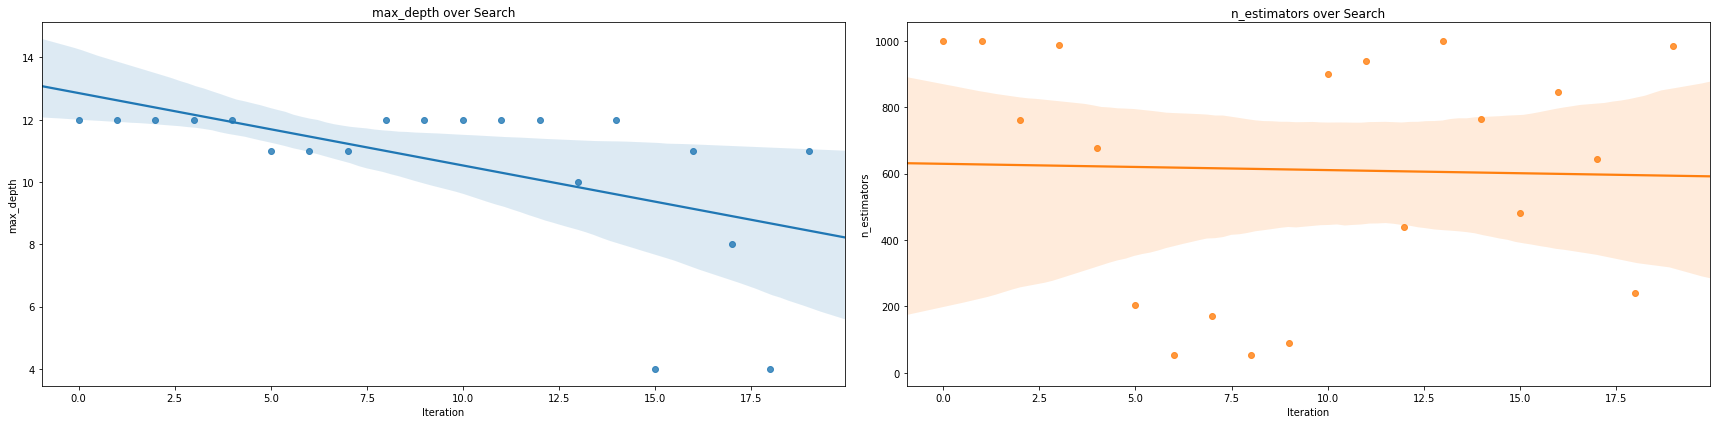

In [13]:
# Plot the value of hyperparameters over the tuning window
plt_hyper.plot_hyperparams_over_search(
    df=tuning_analysis, hyperparams=["max_depth", "n_estimators"]
)

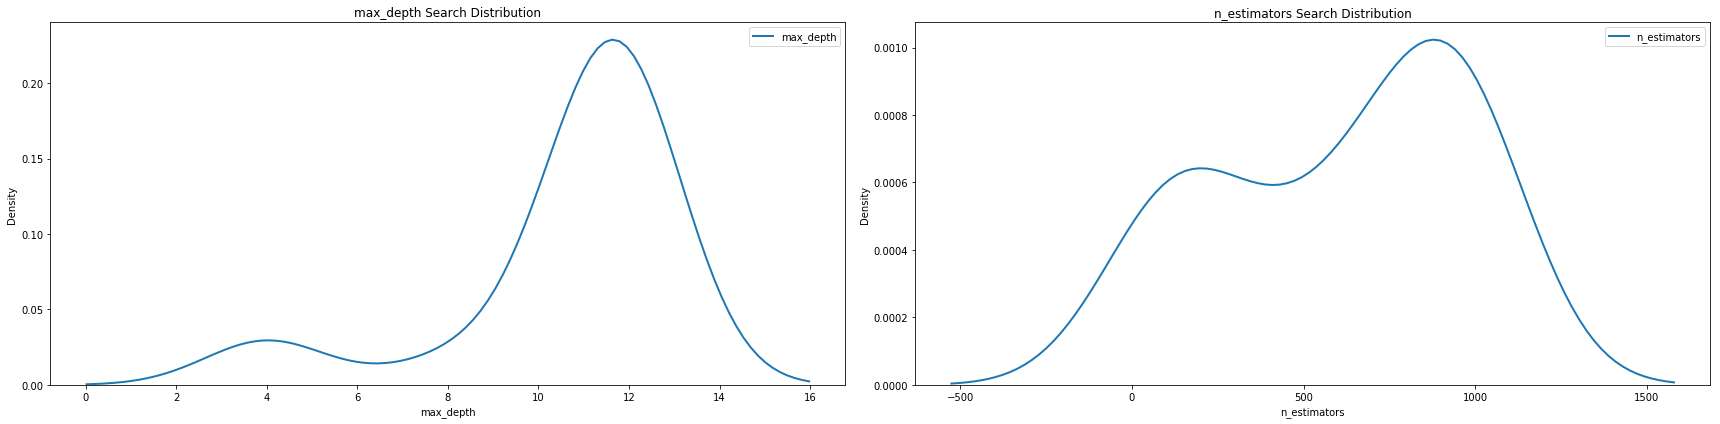

In [14]:
# Create a kde plot of hyperparameters used over the tuning window
plt_hyper.plot_search_dist(
    df=tuning_analysis, hyperparams=["max_depth", "n_estimators"]
)

#### Evaluate on the validation set

In [16]:
# Get the best hyperparameters and refit the model over the training data with the best params
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)
max_depth = int(tuning_analysis["max_depth"].reset_index(drop=True)[0])
n_estimators = int(tuning_analysis["n_estimators"].reset_index(drop=True)[0])
max_features = tuning_analysis["max_features"].reset_index(drop=True)[0]

rf_model = SKLearn(
    entry_point="../Grocery_Recommender/Model_Build/train_rf.py",
    train_instance_type="ml.m5.xlarge",
    hyperparameters={
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "tune": 0,
    },
    role=role,
)

rf_model.fit({"train": preprocessed_training_data})
training_job_description = rf_model.jobs[-1].describe()
model_data_s3_uri = "{}{}/{}".format(
    training_job_description["OutputDataConfig"]["S3OutputPath"],
    training_job_description["TrainingJobName"],
    "output/model.tar.gz",
)

# Run the evaluation on the validation data
sklearn_processor.run(
    code="../Grocery_Recommender/Model_Build/evaluation_sklearn.py",
    inputs=[
        ProcessingInput(
            source=model_data_s3_uri, destination="/opt/ml/processing/model"
        ),
        ProcessingInput(
            source=preprocessed_valid_data, destination="/opt/ml/processing/valid"
        ),
    ],
    outputs=[
        ProcessingOutput(
            output_name="evaluation", source="/opt/ml/processing/evaluation"
        )
    ],
)
evaluation_job_description = sklearn_processor.jobs[-1].describe()

evaluation_output_config = evaluation_job_description["ProcessingOutputConfig"]
for output in evaluation_output_config["Outputs"]:
    if output["OutputName"] == "evaluation":
        evaluation_s3_uri = output["S3Output"]["S3Uri"] + "/evaluation.json"
        break

evaluation_output = S3Downloader.read_file(evaluation_s3_uri)
evaluation_output_dict = json.loads(evaluation_output)
print(json.dumps(evaluation_output_dict, sort_keys=True, indent=4))

2020-04-04 23:17:30 Starting - Starting the training job...
2020-04-04 23:17:32 Starting - Launching requested ML instances...
2020-04-04 23:18:25 Starting - Preparing the instances for training......
2020-04-04 23:19:25 Downloading - Downloading input data
2020-04-04 23:19:25 Training - Downloading the training image..2020-04-04 23:19:39,509 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-04-04 23:19:39,511 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-04 23:19:39,521 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-04-04 23:19:39,753 sagemaker-containers INFO     Module train_rf does not provide a setup.py. 
Generating setup.py
2020-04-04 23:19:39,753 sagemaker-containers INFO     Generating setup.cfg
2020-04-04 23:19:39,754 sagemaker-containers INFO     Generating MANIFEST.in
2020-04-04 23:19:39,754 sagemaker-containers INFO     Installing module with the following comm

.................../miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
Extracting model from path: /opt/ml/processing/model/model.tar.gz
Loading model
Loading validation input data
Creating classification evaluation report
Classification report:
{'0.0': {'precision': 0.9547100211763099, 'recall': 0.9607479205334433, 'f1-score': 0.9577194545329952, 'support': 14547}, '1.0': {'precision': 0.960509025520437, 'recall': 0.9544361212287815, 'f1-score': 0.9574629438124784, 'support': 14551}, 'micro avg': {'precision': 0.9575915870506564, 'recall': 0.9575915870506564, 'f1-score': 0.9575915870506564, 'support': 29098}, 'macro avg': {'precision': 0.9576095233483735, 'recall': 0.9575920208811124, 'f1-score': 0.9575911991727368, 'support': 29098}, 'weighted avg': {'precision': 0.9576099219327672, 'recall': 0.

### Train, tune and evaluate XGBoost Model

#### Prepare data for Sagemaker XGBoost training

In [17]:
# Set up the training, test and validation data how the Sagemaker XGBoost model expects it and upload to S3
# so that Sagemaker can access it
data_dir = "./xgboost_out"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

X_train = pd.read_csv(preprocessed_training_data + "/train_features.csv", header=None)
Y_train = pd.read_csv(preprocessed_training_data + "/train_labels.csv", header=None)
X_test = pd.read_csv(preprocessed_test_data + "/test_features.csv", header=None)
Y_test = pd.read_csv(preprocessed_test_data + "/test_labels.csv", header=None)
X_val = pd.read_csv(preprocessed_valid_data + "/valid_features.csv", header=None)
Y_val = pd.read_csv(preprocessed_valid_data + "/valid_labels.csv", header=None)

prefix = "xgboost_tuning"
X_val.to_csv(os.path.join(data_dir, "validation.csv"), header=False, index=False)
pd.concat([Y_test, X_test], axis=1).to_csv(
    os.path.join(data_dir, "test.csv"), header=False, index=False
)
pd.concat([Y_train, X_train], axis=1).to_csv(
    os.path.join(data_dir, "train.csv"), header=False, index=False
)

test_location = session.upload_data(
    os.path.join(data_dir, "test.csv"), key_prefix=prefix
)
val_location = session.upload_data(
    os.path.join(data_dir, "validation.csv"), key_prefix=prefix
)
train_location = session.upload_data(
    os.path.join(data_dir, "train.csv"), key_prefix=prefix
)

#### Tune the hyperparameters

In [18]:
# Construct the xgboost estimator object
container = get_image_uri(session.boto_region_name, "xgboost", "0.90-1")
prefix = "xgboost"

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(session.default_bucket(), prefix),
    sagemaker_session=session,
)

# Set up the hyperparameter tuning job for XGBoost
xgb.set_hyperparameters(
    objective="reg:logistic", early_stopping_rounds=10, num_round=200
)

xgb_hyperparameter_tuner = HyperparameterTuner(
    estimator=xgb,
    objective_metric_name="validation:auc",
    objective_type="Maximize",
    max_jobs=20,
    max_parallel_jobs=3,
    hyperparameter_ranges={
        "max_depth": IntegerParameter(3, 12),
        "eta": ContinuousParameter(0.05, 0.5),
        "min_child_weight": IntegerParameter(2, 8),
        "subsample": ContinuousParameter(0.5, 0.9),
        "gamma": ContinuousParameter(0, 10),
    },
)

# Tune the XGBoost model
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type="csv")
s3_input_test = sagemaker.s3_input(s3_data=test_location, content_type="csv")

xgb_hyperparameter_tuner.fit({"train": s3_input_train, "validation": s3_input_test})
xgb_hyperparameter_tuner.wait()

# Attach the best training job
xgb_attached = sagemaker.estimator.Estimator.attach(
    xgb_hyperparameter_tuner.best_training_job()
)

# Get analysis on the tuning job including best hyperparameters
tuning_analysis = (
    xgb_hyperparameter_tuner.analytics()
    .dataframe()
    .sort_values(by=["TrainingStartTime"], ascending=False, axis=0)
)

tuning_analysis['iteration'] = tuning_analysis.index
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)

.................................................................................................................................................................................................................................................................................................!
2020-04-04 23:34:46 Starting - Preparing the instances for training
2020-04-04 23:34:46 Downloading - Downloading input data
2020-04-04 23:34:46 Training - Training image download completed. Training in progress.
2020-04-04 23:34:46 Uploading - Uploading generated training model
2020-04-04 23:34:46 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPU

Training seconds: 78
Billable seconds: 78


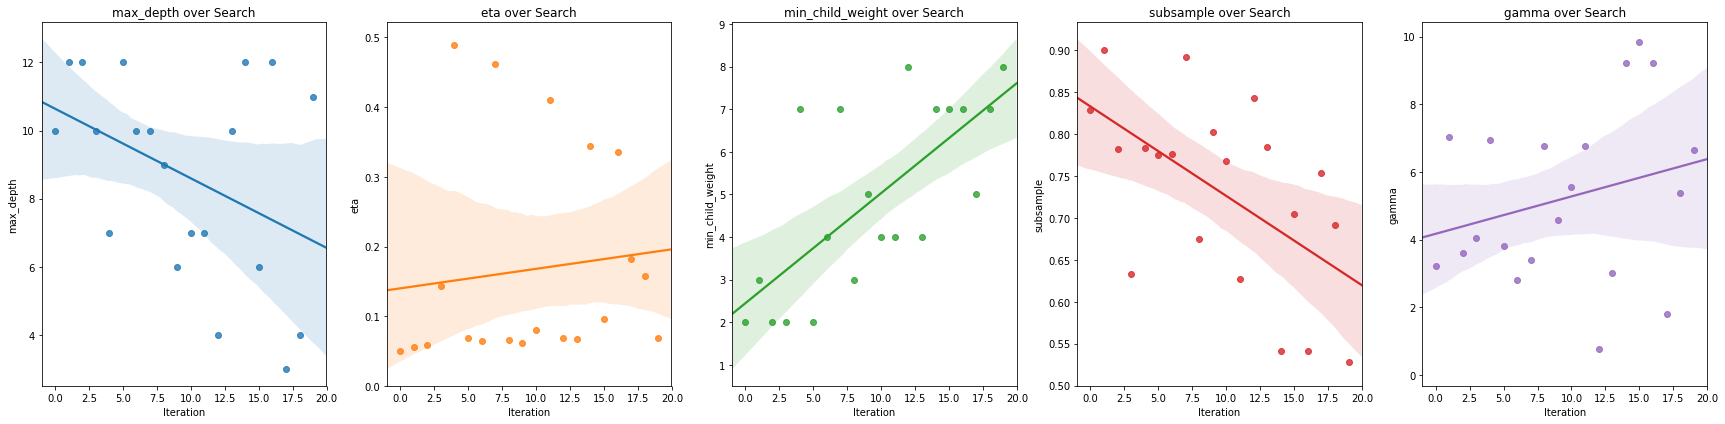

In [19]:
# Plot the value of hyperparameters over the tuning window
plt_hyper.plot_hyperparams_over_search(
    df=tuning_analysis,
    hyperparams=["max_depth", "eta", "min_child_weight", "subsample", "gamma"],
)

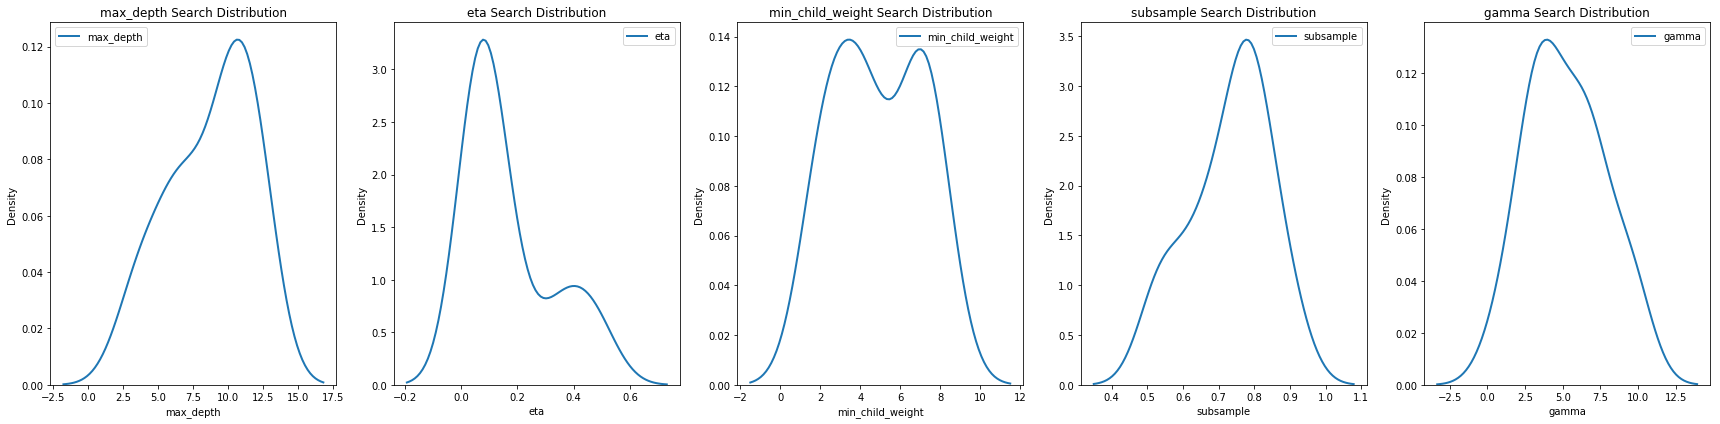

In [20]:
# Create a kde plot of hyperparameters used over the tuning window
plt_hyper.plot_search_dist(
    df=tuning_analysis,
    hyperparams=["max_depth", "eta", "min_child_weight", "subsample", "gamma"],
)

#### Evaluate on the validation set 

In [21]:
# Evaluate the XGBoost model on the validation data
XGBoost_eval.evaluate_xgboost(
    tuned_model=xgb_attached,
    val_data_location=val_location,
    pred_out=data_dir,
    proba_cutoff=0.5,
    Y_val=Y_val,
)

.....................[2020-04-04 23:52:15 +0000] [14] [INFO] Starting gunicorn 19.10.0
[2020-04-04 23:52:15 +0000] [14] [INFO] Listening at: unix:/tmp/gunicorn.sock (14)
[2020-04-04 23:52:15 +0000] [14] [INFO] Using worker: gevent
[2020-04-04 23:52:15 +0000] [21] [INFO] Booting worker with pid: 21
[2020-04-04 23:52:15 +0000] [22] [INFO] Booting worker with pid: 22
[2020-04-04 23:52:15 +0000] [23] [INFO] Booting worker with pid: 23
[2020-04-04 23:52:15 +0000] [27] [INFO] Booting worker with pid: 27
[2020-04-04:23:52:36:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [04/Apr/2020:23:52:36 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-04-04:23:52:36:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [04/Apr/2020:23:52:36 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-04-04:23:52:37:INFO] No GPUs detected (normal if no gpus installed)
[2020-04-04:23:52:37:INFO] No GPUs detected (normal if n